In [5]:
%load_ext autoreload
%autoreload 2
     
import torch
import os
from matplotlib import pyplot as plt
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders
from math import prod
from torchvision import transforms

import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset
from csng.imagenet.models import ReadIn, ResnetExtractor, UpsampleModel


assert torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


NameError: name 'nn' is not defined

In [610]:

device = os.environ["DEVICE"]
DATA_PATH = os.environ['DATA_PATH']
CACHE_DIR = os.path.join(DATA_PATH, 'brainreader_cache')
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, 'brainreader')

BATCH_SIZE = 64
EPOCHS = 50
WEIGHT_DECAY=0e-4
LEARNING_RATE = .0002* BATCH_SIZE
READIN_DTYPE = torch.bfloat16
RESNET_DECODE_MODEL = '/scratch/izar/vanousek/cs-433-project/models/mlp2489100.pt'

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [620]:
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "encoder_ball_50.pt"),
    # "load_ckpt": os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    "train": True,
}
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": BATCH_SIZE,
    # "sessions": list(range(1, 23)),
    "sessions": [1],
    "resize_stim_to": (224, 224),
    "normalize_stim": False,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": True,
    "additional_keys": None,
    "avg_test_resp": True,
}

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
print(len(dl['train']), len(dl['test']))

71 2


1
torch.Size([64, 1, 224, 224])
torch.Size([64, 9395])
1


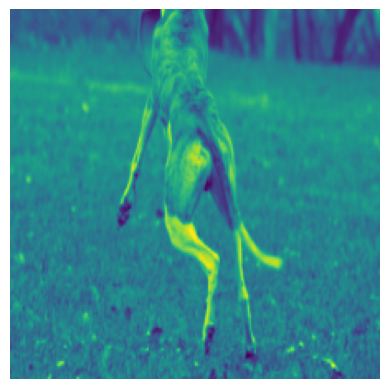

In [612]:
def show_image(img_tensor, title=''):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

items = next(dl['train'])
print(len(items))
item = items[0]
stim = item['stim']
print(stim.shape)

resp = item['resp']
print(resp.shape)
neurons = resp.shape[1]
data_key = item['data_key']
print(data_key)
# plot the stim as grayscale image with matplotlib
show_image(stim[0]) 


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [614]:
import torch
from torch.nn import functional as F
from math import prod

readin.apply(initialize_weights)



readin = RidgeRegressor(neurons, (1024, 14, 14))
readin.to(device, dtype=READIN_DTYPE)
    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(readin)
print("Total parametrs: ", params)

Total parametrs:  240616448


In [615]:

optimizer = torch.optim.Adam(readin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dl['train'])*EPOCHS, eta_min=LEARNING_RATE/5)

extractor = ResnetExtractor()

losses = []


for epoch in range(EPOCHS):
    dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
    for minibatch in tqdm(dl['train']):
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)

        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        
        with torch.cuda.amp.autocast():
            pass
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)
        output = readin(resp)
        loss = criterion(output, target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(readin.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)
        losses.append(relative_loss)
        # print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")

        optimizer.zero_grad()
    print(f"Epoch {epoch} finished with relative loss {np.mean(losses[-len(dl['train']):])}")



Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 0 finished with relative loss 3.7538220977506334


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 1 finished with relative loss 0.3623322814752435


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 2 finished with relative loss 0.22170931140067254


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 3 finished with relative loss 0.21192976604602895


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 4 finished with relative loss 0.20522973531607658


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:22<00:00,  3.23it/s]


Epoch 5 finished with relative loss 0.19964453477355612


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 6 finished with relative loss 0.19482585211802725


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 7 finished with relative loss 0.18994133074096814


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 8 finished with relative loss 0.18484323875753322


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 9 finished with relative loss 0.1800861041764424


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 10 finished with relative loss 0.17553810566445893


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 11 finished with relative loss 0.16990872953232827


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 12 finished with relative loss 0.16462403352020413


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 13 finished with relative loss 0.15913126804924776


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 14 finished with relative loss 0.15404318988964272


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 15 finished with relative loss 0.1487467525557606


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 16 finished with relative loss 0.1435122656442154


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.23it/s]


Epoch 17 finished with relative loss 0.13880962688466494


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 18 finished with relative loss 0.13393956781922614


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 19 finished with relative loss 0.12944977028360158


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 20 finished with relative loss 0.12530358643262926


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 21 finished with relative loss 0.12120361165427093


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 22 finished with relative loss 0.1171481886323117


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 23 finished with relative loss 0.1132702016492888


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 24 finished with relative loss 0.10990086862576391


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 25 finished with relative loss 0.10698913824396918


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 26 finished with relative loss 0.10384983804376348


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 27 finished with relative loss 0.10087066981995403


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 28 finished with relative loss 0.09833134176490811


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.24it/s]


Epoch 29 finished with relative loss 0.09582596760986861


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 30 finished with relative loss 0.09370205854742814


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 31 finished with relative loss 0.09170113578048088


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 32 finished with relative loss 0.08985193325793908


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 33 finished with relative loss 0.08810867414645417


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 34 finished with relative loss 0.08677195177089048


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 35 finished with relative loss 0.08549037224006212


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 36 finished with relative loss 0.08440603216888772


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 37 finished with relative loss 0.08325963161173812


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 38 finished with relative loss 0.08229184693465028


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 39 finished with relative loss 0.08189860009114548


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 40 finished with relative loss 0.08097413436310234


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.24it/s]


Epoch 41 finished with relative loss 0.08072155336416932


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 42 finished with relative loss 0.08008173857984481


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 43 finished with relative loss 0.07987352229451886


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 44 finished with relative loss 0.07917334447905555


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 45 finished with relative loss 0.07926665528620426


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 46 finished with relative loss 0.07882606289329938


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 47 finished with relative loss 0.07865095376859459


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 48 finished with relative loss 0.07815213612194336


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]

Epoch 49 finished with relative loss 0.07801933783990117


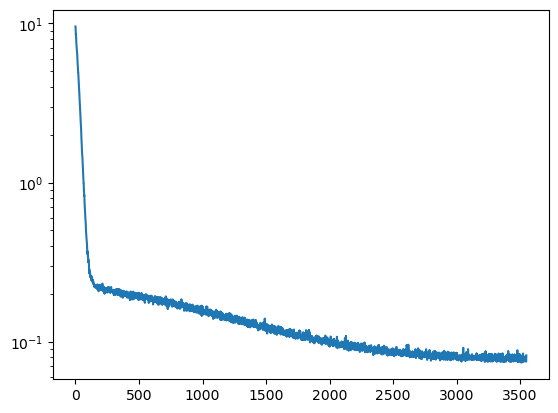

In [616]:
# Plot losses
plt.plot(losses)
plt.yscale('log')


In [617]:
# Evaluate the model
readin.eval()
test_losses = []
imgs = []
imgnet_activations_real = []
imgnet_activations_pred = []

with torch.no_grad():
    for minibatch in dl['test']:
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)
        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

        output = readin(resp)

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)

        test_losses.append(relative_loss)
        imgnet_activations_real.append(target)
        imgnet_activations_pred.append(output)
        imgs.append(stim)

        print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")
        print(f"Loss: {loss.item()}")
# .22
print(f"Mean loss: {np.mean(test_losses)}")
print(f"Std loss: {np.std(test_losses)}")

/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.0096435546875 Constant loss: 0.1162109375 Relative loss: 0.08298247920959066
Loss: 0.0096435546875
Loss: 0.0096435546875 Constant loss: 0.1181640625 Relative loss: 0.08161087959057273
Loss: 0.0096435546875
Mean loss: 0.0822966794000817
Std loss: 0.0006857998095089676


/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 36, 1024, 14, 14])) that is different to the input size (torch.Size([36, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:

output_model = torch.load(RESNET_DECODE_MODEL)
output_model.eval()
for real, recon, pred in zip(imgs, imgnet_activations_real, imgnet_activations_pred):
    plt.figure()
    with torch.no_grad():
        real_img = output_model(real.to('cuda', dtype=torch.float32).squeeze()).squeeze()
        print(real_img.shape)
        for i in range(1, 10):
            plt.figure()
            print(real_img.shape)
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            pred_img = output_model(pred.to('cuda', dtype=torch.float32)).squeeze()
            plt.figure()
            plt.imshow(pred_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.show()

RuntimeError: Given transposed=1, weight of size [1024, 768, 4, 4], expected input[1, 64, 224, 224] to have 1024 channels, but got 64 channels instead

<Figure size 640x480 with 0 Axes>